#### Import packages

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from learning2rank.rank import RankNet
from learning2rank.rank import ListNet

#### Read Data 

In [2]:
# Read in our input data
train = pd.read_csv('../Dataset/train/train.csv')
test = pd.read_csv('../Dataset/test/test.csv')


# This prints out (rows, columns) in each dataframe
print('Train shape:', train.shape)
print('Test shape:', test.shape)


id_train = train['id'].values
y = train.target.values
id_test = test['id'].values

('Train shape:', (595212, 59))
('Test shape:', (892816, 58))


In [3]:
# Define the gini metric - from https://www.kaggle.com/c/ClaimPredictionChallenge/discussion/703#5897
def gini(actual, pred, cmpcol = 0, sortcol = 1):
    assert( len(actual) == len(pred) )
    all = np.asarray(np.c_[ actual, pred, np.arange(len(actual)) ], dtype=np.float)
    all = all[ np.lexsort((all[:,2], -1*all[:,1])) ]
    totalLosses = all[:,0].sum()
    giniSum = all[:,0].cumsum().sum() / totalLosses
    
    giniSum -= (len(actual) + 1) / 2.
    return giniSum / len(actual)
 
def gini_normalized(a, p):
    return gini(a, p) / gini(a, a)

# Create an XGBoost-compatible metric from Gini

def gini_xgb(preds, dtrain):
    labels = dtrain.get_label()
    gini_score = gini_normalized(labels, preds)
    return 'gini', gini_score

def gini_lgb(preds, dtrain):
    labels = dtrain.get_label()
    gini_score = gini_normalized(labels, preds)
    return 'gini', 1-gini_score, False

In [4]:
# We drop these variables as we don't want to train on them
# The other 57 columns are all numerical and can be trained on without preprocessing

train['countNAs'] = train.isin(['-1']).sum(axis=1)
test['countNAs'] = test.isin(['-1']).sum(axis=1)

train = train.drop(['id','target'], axis=1)
test = test.drop(['id'], axis=1)

# train_cont = train.drop(['id','ps_ind_02_cat','ps_ind_04_cat','ps_ind_05_cat','ps_car_01_cat',
#                     'ps_car_02_cat','ps_car_03_cat','ps_car_04_cat','ps_car_05_cat',
#                     'ps_car_06_cat','ps_car_07_cat','ps_car_08_cat','ps_car_09_cat',
#                     'ps_car_10_cat','ps_car_11_cat','target'], axis=1)
# test_cont = test.drop(['id','ps_ind_02_cat','ps_ind_04_cat','ps_ind_05_cat','ps_car_01_cat',
#                     'ps_car_02_cat','ps_car_03_cat','ps_car_04_cat','ps_car_05_cat',
#                     'ps_car_06_cat','ps_car_07_cat','ps_car_08_cat','ps_car_09_cat',
#                     'ps_car_10_cat','ps_car_11_cat'], axis=1)

# # One-hot encoding
# one_hot = OneHotEncoder()
# train_cat = train[['ps_ind_02_cat','ps_ind_04_cat','ps_ind_05_cat','ps_car_01_cat',
#                     'ps_car_02_cat','ps_car_03_cat','ps_car_04_cat','ps_car_05_cat',
#                     'ps_car_06_cat','ps_car_07_cat','ps_car_08_cat','ps_car_09_cat',
#                     'ps_car_10_cat','ps_car_11_cat']]
# test_cat = test[['ps_ind_02_cat','ps_ind_04_cat','ps_ind_05_cat','ps_car_01_cat',
#                     'ps_car_02_cat','ps_car_03_cat','ps_car_04_cat','ps_car_05_cat',
#                     'ps_car_06_cat','ps_car_07_cat','ps_car_08_cat','ps_car_09_cat',
#                     'ps_car_10_cat','ps_car_11_cat']]

# train_cat = train_cat.replace(-1, 999)
# test_cat = test_cat.replace(-1, 999)

# train_cat = one_hot.fit_transform(train_cat).toarray()
# test_cat = one_hot.fit_transform(test_cat).toarray()

# X = np.concatenate((train_cat, train_cont.values), axis=1)
# test = np.concatenate((test_cat, test_cont.values), axis=1)
# standardise = StandardScaler()
# standardise = standardise.fit(X)
# X = standardise.transform(X)
# test = standardise.transform(test)
# # print('Train shape:', train.shape)
# # print('Test shape:', test.shape)

In [5]:
X = train.values

In [6]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

#### RankNet 

In [10]:
model = RankNet.RankNet()

In [11]:
model.fit(X_train, y_train, 
          batchsize=100, n_iter=5000, n_units1=512, n_units2=128, tv_ratio=0.8,
          optimizerAlgorithm="Adam", savefigName="result.pdf", savemodelName="RankNet.model")

  0%|          | 0/5000 [00:00<?, ?it/s]

load dataset
('The number of data, train:', 380935, 'validate:', 95234)
prepare initialized model!


  3%|▎         | 161/5000 [00:01<00:54, 88.72it/s]

step: 100
NDCG@100 | train: 0.0734669888251, test: 0.0616783233232


  5%|▌         | 261/5000 [00:03<01:04, 73.92it/s]

step: 200
NDCG@100 | train: 0.143841001285, test: 0.0417503389691


  7%|▋         | 362/5000 [00:05<01:07, 69.19it/s]

step: 300
NDCG@100 | train: 0.024041319355, test: 0.0317844766396


  9%|▉         | 461/5000 [00:06<01:08, 66.26it/s]

step: 400
NDCG@100 | train: 0.0875006159397, test: 0.0300361195331


 11%|█         | 561/5000 [00:08<01:08, 64.55it/s]

step: 500
NDCG@100 | train: 0.0439412912319, test: 0.107212473947


 13%|█▎        | 661/5000 [00:10<01:08, 63.45it/s]

step: 600
NDCG@100 | train: 0.0456311650737, test: 0.0882331223579


 15%|█▌        | 753/5000 [00:12<01:08, 61.99it/s]

step: 700
NDCG@100 | train: 0.0498336764605, test: 0.0397500077792


 17%|█▋        | 844/5000 [00:13<01:08, 60.84it/s]

step: 800
NDCG@100 | train: 0.0397159444897, test: 0.0285009065917


 19%|█▉        | 966/5000 [00:15<01:05, 61.59it/s]

step: 900
NDCG@100 | train: 0.0406937047313, test: 0.0780913228984


 21%|██        | 1044/5000 [00:17<01:05, 60.04it/s]

step: 1000
NDCG@100 | train: 0.0873985782474, test: 0.0349569510321


 23%|██▎       | 1165/5000 [00:19<01:03, 60.70it/s]

step: 1100
NDCG@100 | train: 0.0438517417961, test: 0.0327714942258


 25%|██▍       | 1244/5000 [00:20<01:03, 59.57it/s]

step: 1200
NDCG@100 | train: 0.0743265158343, test: 0.0718647332114


 27%|██▋       | 1364/5000 [00:22<01:00, 60.18it/s]

step: 1300
NDCG@100 | train: 0.0220961754455, test: 0.0435133517722


 29%|██▉       | 1443/5000 [00:24<01:00, 59.26it/s]

step: 1400
NDCG@100 | train: 0.0561176976347, test: 0.0592542458928


 31%|███       | 1561/5000 [00:26<00:57, 59.70it/s]

step: 1500
NDCG@100 | train: 0.0230215565699, test: 0.109638179022


 33%|███▎      | 1642/5000 [00:27<00:56, 58.98it/s]

step: 1600
NDCG@100 | train: 0.0761288189914, test: 0.0831689263449


 35%|███▌      | 1758/5000 [00:29<00:54, 59.33it/s]

step: 1700
NDCG@100 | train: 0.0316138232114, test: 0.13795044833


 37%|███▋      | 1872/5000 [00:31<00:52, 59.61it/s]

step: 1800
NDCG@100 | train: 0.0554173068353, test: 0.128961238008


 39%|███▉      | 1942/5000 [00:33<00:52, 58.71it/s]

step: 1900
NDCG@100 | train: 0.0759008795063, test: 0.117318462497


 41%|████      | 2055/5000 [00:34<00:49, 58.93it/s]

step: 2000
NDCG@100 | train: 0.0506465590566, test: 0.108259797575


 43%|████▎     | 2168/5000 [00:36<00:47, 59.14it/s]

step: 2100
NDCG@100 | train: 0.0742920559433, test: 0.100760021317


 45%|████▍     | 2240/5000 [00:38<00:47, 58.45it/s]

step: 2200
NDCG@100 | train: 0.053923890633, test: 0.0313603254612


 47%|████▋     | 2351/5000 [00:40<00:45, 58.60it/s]

step: 2300
NDCG@100 | train: 0.0889479905805, test: 0.129624426641


 49%|████▉     | 2463/5000 [00:41<00:43, 58.76it/s]

step: 2400
NDCG@100 | train: 0.131129852462, test: 0.116827263295


 51%|█████     | 2540/5000 [00:43<00:42, 58.22it/s]

step: 2500
NDCG@100 | train: 0.109926220261, test: 0.145717904343


 53%|█████▎    | 2651/5000 [00:45<00:40, 58.40it/s]

step: 2600
NDCG@100 | train: 0.147491588801, test: 0.115957651277


 55%|█████▌    | 2762/5000 [00:47<00:38, 58.55it/s]

step: 2700
NDCG@100 | train: 0.131496165771, test: 0.0970652680131


 57%|█████▋    | 2840/5000 [00:48<00:37, 58.11it/s]

step: 2800
NDCG@100 | train: 0.0801641396727, test: 0.0422439768065


 59%|█████▉    | 2949/5000 [00:50<00:35, 58.20it/s]

step: 2900
NDCG@100 | train: 0.0763159863635, test: 0.0775234709384


 61%|██████    | 3059/5000 [00:52<00:33, 58.30it/s]

step: 3000
NDCG@100 | train: 0.0346093836848, test: 0.0686848423558


 63%|██████▎   | 3168/5000 [00:54<00:31, 58.40it/s]

step: 3100
NDCG@100 | train: 0.0367657217901, test: 0.0323444912889


 65%|██████▍   | 3239/5000 [00:55<00:30, 57.93it/s]

step: 3200
NDCG@100 | train: 0.027769342211, test: 0.0462937070816


 67%|██████▋   | 3347/5000 [00:57<00:28, 58.00it/s]

step: 3300
NDCG@100 | train: 0.0839193537697, test: 0.0234288535604


 69%|██████▉   | 3454/5000 [00:59<00:26, 58.06it/s]

step: 3400
NDCG@100 | train: 0.0883287891157, test: 0.00751209321231


 71%|███████   | 3559/5000 [01:01<00:24, 58.10it/s]

step: 3500
NDCG@100 | train: 0.0893872475027, test: 0.0945823707225


 73%|███████▎  | 3665/5000 [01:03<00:22, 58.17it/s]

step: 3600
NDCG@100 | train: 0.0256623837001, test: 0.0244557279736


 75%|███████▍  | 3737/5000 [01:04<00:21, 57.78it/s]

step: 3700
NDCG@100 | train: 0.0507248750452, test: 0.0305050619532


 77%|███████▋  | 3841/5000 [01:06<00:20, 57.80it/s]

step: 3800
NDCG@100 | train: 0.0846975037594, test: 0.0733020087676


 79%|███████▉  | 3946/5000 [01:08<00:18, 57.85it/s]

step: 3900
NDCG@100 | train: 0.0821111723561, test: 0.0192605581832


 81%|████████  | 4051/5000 [01:09<00:16, 57.92it/s]

step: 4000
NDCG@100 | train: 0.0345490892746, test: 0.0384251012498


 83%|████████▎ | 4155/5000 [01:11<00:14, 57.95it/s]

step: 4100
NDCG@100 | train: 0.0427102788838, test: 0.0573699756156


 85%|████████▌ | 4258/5000 [01:13<00:12, 57.95it/s]

step: 4200
NDCG@100 | train: 0.0758504167259, test: 0.0359183367001


 87%|████████▋ | 4362/5000 [01:15<00:11, 57.98it/s]

step: 4300
NDCG@100 | train: 0.105931703194, test: 0.0810254415504


 89%|████████▉ | 4467/5000 [01:16<00:09, 58.03it/s]

step: 4400
NDCG@100 | train: 0.112597123666, test: 0.05598629064


 91%|█████████ | 4537/5000 [01:18<00:08, 57.70it/s]

step: 4500
NDCG@100 | train: 0.109251033127, test: 0.0721073746468


 93%|█████████▎| 4640/5000 [01:20<00:06, 57.71it/s]

step: 4600
NDCG@100 | train: 0.109066951281, test: 0.0685078318454


 95%|█████████▍| 4743/5000 [01:22<00:04, 57.73it/s]

step: 4700
NDCG@100 | train: 0.0340313218002, test: 0.077136382631


 97%|█████████▋| 4847/5000 [01:23<00:02, 57.74it/s]

step: 4800
NDCG@100 | train: 0.0960204608238, test: 0.0238033321937


 99%|█████████▉| 4950/5000 [01:25<00:00, 57.74it/s]

step: 4900
NDCG@100 | train: 0.0423879033843, test: 0.111161521527


100%|██████████| 5000/5000 [01:27<00:00, 57.23it/s]

step: 5000
NDCG@100 | train: 0.0915668364523, test: 0.0420745086167
save the model
save the optimizer


In [21]:
pred_val = model.predict(X_val)

In [19]:
gini_normalized(y_val, pred_val)

-0.032743058415376149

A waste!

#### ListNet

In [7]:
model = ListNet.ListNet()

In [ ]:
model.fit(X_train, y_train, 
          batchsize=100, n_epoch=50, n_units1=1000, n_units2=1000, tv_ratio=0.8, 
          optimizerAlgorithm="Adam", savefigName="result.pdf", savemodelName="ListNet.model")

  0%|          | 0/3810 [00:00<?, ?it/s]

load dataset
('The number of data, train:', 380935, 'validate:', 95234)
prepare initialized model!
Start training and validation loop......
('epoch', 1)


  6%|▌         | 57/953 [00:00<00:01, 564.65it/s]

train mean loss=0.0415852282434


100%|██████████| 953/953 [00:01<00:00, 570.72it/s]


test  mean loss=0.0


  0%|          | 8/3810 [00:00<00:51, 73.74it/s]

epoch: 2
NDCG@100 | train: 0.0251646568178, test: 0.025829837313
('epoch', 2)


  6%|▌         | 58/953 [00:00<00:01, 576.82it/s]

train mean loss=0.0


100%|██████████| 953/953 [00:01<00:00, 573.70it/s]


test  mean loss=0.0


  0%|          | 8/3810 [00:00<00:50, 74.60it/s]

epoch: 3
NDCG@100 | train: 0.0251646568178, test: 0.025829837313
('epoch', 3)


  6%|▌         | 58/953 [00:00<00:01, 575.92it/s]

train mean loss=0.0


100%|██████████| 953/953 [00:01<00:00, 572.93it/s]


test  mean loss=0.0


  0%|          | 8/3810 [00:00<00:51, 73.27it/s]

epoch: 4
NDCG@100 | train: 0.0251646568178, test: 0.025829837313
('epoch', 4)


  6%|▌         | 58/953 [00:00<00:01, 575.93it/s]

train mean loss=0.0


100%|██████████| 953/953 [00:01<00:00, 573.89it/s]


test  mean loss=0.0


  0%|          | 8/3810 [00:00<00:51, 74.01it/s]

epoch: 5
NDCG@100 | train: 0.0251646568178, test: 0.025829837313
('epoch', 5)


  6%|▌         | 58/953 [00:00<00:01, 576.53it/s]

train mean loss=0.0


100%|██████████| 953/953 [00:01<00:00, 572.95it/s]


test  mean loss=0.0


  0%|          | 8/3810 [00:00<00:51, 73.65it/s]

epoch: 6
NDCG@100 | train: 0.0251646568178, test: 0.025829837313
('epoch', 6)


  6%|▌         | 58/953 [00:00<00:01, 573.17it/s]

train mean loss=0.0


100%|██████████| 953/953 [00:01<00:00, 571.62it/s]


test  mean loss=0.0


  0%|          | 8/3810 [00:00<00:51, 73.39it/s]

epoch: 7
NDCG@100 | train: 0.0251646568178, test: 0.025829837313
('epoch', 7)


  6%|▌         | 58/953 [00:00<00:01, 573.77it/s]

train mean loss=0.0


100%|██████████| 953/953 [00:01<00:00, 571.66it/s]


test  mean loss=0.0


  0%|          | 8/3810 [00:00<00:52, 72.84it/s]

epoch: 8
NDCG@100 | train: 0.0251646568178, test: 0.025829837313
('epoch', 8)


  6%|▌         | 58/953 [00:00<00:01, 572.03it/s]

train mean loss=0.0


100%|██████████| 953/953 [00:01<00:00, 569.96it/s]


test  mean loss=0.0


  0%|          | 8/3810 [00:00<00:51, 73.64it/s]

epoch: 9
NDCG@100 | train: 0.0251646568178, test: 0.025829837313
('epoch', 9)


  6%|▌         | 58/953 [00:00<00:01, 573.24it/s]

train mean loss=0.0


100%|██████████| 953/953 [00:01<00:00, 570.30it/s]


test  mean loss=0.0


  0%|          | 8/3810 [00:00<00:51, 73.67it/s]

epoch: 10
NDCG@100 | train: 0.0251646568178, test: 0.025829837313
('epoch', 10)


  6%|▌         | 58/953 [00:00<00:01, 576.07it/s]

train mean loss=0.0


100%|██████████| 953/953 [00:01<00:00, 571.64it/s]


test  mean loss=0.0


  0%|          | 8/3810 [00:00<00:52, 72.95it/s]

epoch: 11
NDCG@100 | train: 0.0251646568178, test: 0.025829837313
('epoch', 11)


  6%|▌         | 58/953 [00:00<00:01, 572.46it/s]

train mean loss=0.0


100%|██████████| 953/953 [00:01<00:00, 570.92it/s]


test  mean loss=0.0


  0%|          | 8/3810 [00:00<00:51, 73.43it/s]

epoch: 12
NDCG@100 | train: 0.0251646568178, test: 0.025829837313
('epoch', 12)


  6%|▌         | 58/953 [00:00<00:01, 571.94it/s]

train mean loss=0.0


100%|██████████| 953/953 [00:01<00:00, 569.80it/s]


test  mean loss=0.0


  0%|          | 8/3810 [00:00<00:51, 73.85it/s]

epoch: 13
NDCG@100 | train: 0.0251646568178, test: 0.025829837313
('epoch', 13)


  6%|▌         | 58/953 [00:00<00:01, 572.73it/s]

train mean loss=0.0


100%|██████████| 953/953 [00:01<00:00, 571.26it/s]


test  mean loss=0.0


  0%|          | 8/3810 [00:00<00:51, 73.80it/s]

epoch: 14
NDCG@100 | train: 0.0251646568178, test: 0.025829837313
('epoch', 14)


  6%|▌         | 58/953 [00:00<00:01, 575.06it/s]

train mean loss=0.0


100%|██████████| 953/953 [00:01<00:00, 574.14it/s]


test  mean loss=0.0


  0%|          | 8/3810 [00:00<00:51, 74.04it/s]

epoch: 15
NDCG@100 | train: 0.0251646568178, test: 0.025829837313
('epoch', 15)


  6%|▌         | 58/953 [00:00<00:01, 578.77it/s]

train mean loss=0.0


100%|██████████| 953/953 [00:01<00:00, 575.60it/s]


test  mean loss=0.0


  0%|          | 8/3810 [00:00<00:51, 74.17it/s]

epoch: 16
NDCG@100 | train: 0.0251646568178, test: 0.025829837313
('epoch', 16)


  6%|▌         | 58/953 [00:00<00:01, 577.15it/s]

train mean loss=0.0


100%|██████████| 953/953 [00:01<00:00, 575.23it/s]


test  mean loss=0.0


  0%|          | 8/3810 [00:00<00:51, 73.79it/s]

epoch: 17
NDCG@100 | train: 0.0251646568178, test: 0.025829837313
('epoch', 17)


  6%|▌         | 58/953 [00:00<00:01, 578.08it/s]

train mean loss=0.0


100%|██████████| 953/953 [00:01<00:00, 577.11it/s]


test  mean loss=0.0


  0%|          | 8/3810 [00:00<00:51, 73.90it/s]

epoch: 18
NDCG@100 | train: 0.0251646568178, test: 0.025829837313
('epoch', 18)


  6%|▌         | 58/953 [00:00<00:01, 577.31it/s]

train mean loss=0.0


100%|██████████| 953/953 [00:01<00:00, 574.20it/s]


test  mean loss=0.0


  0%|          | 8/3810 [00:00<00:51, 73.51it/s]

epoch: 19
NDCG@100 | train: 0.0251646568178, test: 0.025829837313
('epoch', 19)


  6%|▌         | 59/953 [00:00<00:01, 583.70it/s]

train mean loss=0.0


100%|██████████| 953/953 [00:01<00:00, 579.68it/s]


test  mean loss=0.0


  0%|          | 8/3810 [00:00<00:51, 74.24it/s]

epoch: 20
NDCG@100 | train: 0.0251646568178, test: 0.025829837313
('epoch', 20)


  6%|▌         | 58/953 [00:00<00:01, 573.49it/s]

train mean loss=0.0


100%|██████████| 953/953 [00:01<00:00, 578.55it/s]


test  mean loss=0.0


  0%|          | 8/3810 [00:00<00:51, 73.97it/s]

epoch: 21
NDCG@100 | train: 0.0251646568178, test: 0.025829837313
('epoch', 21)


  6%|▌         | 59/953 [00:00<00:01, 580.21it/s]

train mean loss=0.0


100%|██████████| 953/953 [00:01<00:00, 578.36it/s]


test  mean loss=0.0


  0%|          | 8/3810 [00:00<00:51, 73.48it/s]

epoch: 22
NDCG@100 | train: 0.0251646568178, test: 0.025829837313
('epoch', 22)


  6%|▌         | 58/953 [00:00<00:01, 578.09it/s]

train mean loss=0.0


100%|██████████| 953/953 [00:01<00:00, 576.84it/s]


test  mean loss=0.0


  0%|          | 8/3810 [00:00<00:51, 73.83it/s]

epoch: 23
NDCG@100 | train: 0.0251646568178, test: 0.025829837313
('epoch', 23)


  6%|▌         | 58/953 [00:00<00:01, 571.48it/s]

train mean loss=0.0


100%|██████████| 953/953 [00:01<00:00, 576.33it/s]


test  mean loss=0.0


  0%|          | 8/3810 [00:00<00:51, 74.10it/s]

epoch: 24
NDCG@100 | train: 0.0251646568178, test: 0.025829837313
('epoch', 24)


  6%|▌         | 58/953 [00:00<00:01, 576.33it/s]

train mean loss=0.0


100%|██████████| 953/953 [00:01<00:00, 574.39it/s]


test  mean loss=0.0


  0%|          | 8/3810 [00:00<00:51, 73.90it/s]

epoch: 25
NDCG@100 | train: 0.0251646568178, test: 0.025829837313
('epoch', 25)


  6%|▌         | 59/953 [00:00<00:01, 581.59it/s]

train mean loss=0.0


100%|██████████| 953/953 [00:01<00:00, 579.68it/s]


test  mean loss=0.0


  0%|          | 8/3810 [00:00<00:52, 73.01it/s]

epoch: 26
NDCG@100 | train: 0.0251646568178, test: 0.025829837313
('epoch', 26)


  6%|▌         | 58/953 [00:00<00:01, 579.63it/s]

train mean loss=0.0


100%|██████████| 953/953 [00:01<00:00, 578.11it/s]


test  mean loss=0.0


  0%|          | 8/3810 [00:00<00:51, 73.63it/s]

epoch: 27
NDCG@100 | train: 0.0251646568178, test: 0.025829837313
('epoch', 27)


  6%|▌         | 58/953 [00:00<00:01, 576.31it/s]

train mean loss=0.0


100%|██████████| 953/953 [00:01<00:00, 573.95it/s]


test  mean loss=0.0


  0%|          | 8/3810 [00:00<00:51, 74.16it/s]

epoch: 28
NDCG@100 | train: 0.0251646568178, test: 0.025829837313
('epoch', 28)


  6%|▌         | 58/953 [00:00<00:01, 577.57it/s]

train mean loss=0.0


100%|██████████| 953/953 [00:01<00:00, 576.87it/s]


test  mean loss=0.0


  0%|          | 8/3810 [00:00<00:51, 74.48it/s]

epoch: 29
NDCG@100 | train: 0.0251646568178, test: 0.025829837313
('epoch', 29)


  6%|▌         | 58/953 [00:00<00:01, 574.29it/s]

train mean loss=0.0


100%|██████████| 953/953 [00:01<00:00, 570.83it/s]


test  mean loss=0.0


  0%|          | 8/3810 [00:00<00:51, 73.69it/s]

epoch: 30
NDCG@100 | train: 0.0251646568178, test: 0.025829837313
('epoch', 30)


 60%|██████    | 2288/3810 [00:31<00:20, 73.06it/s]

In [9]:
pred_val = model.predict(X_val)

In [10]:
gini_normalized(y_val, pred_val)

0.0094413502746843354

In [11]:
# Create a submission file
sub = pd.DataFrame()
sub['id'] = id_test
sub['target'] = np.zeros_like(id_test)

kfold = 5
weights = []
sss = StratifiedKFold(n_splits=kfold, random_state=0)
for i, (train_index, test_index) in enumerate(sss.split(X, y)):
    print('[Fold %d/%d]' % (i + 1, kfold))
    X_train, X_valid = X[train_index], X[test_index]
    y_train, y_valid = y[train_index], y[test_index]
    # Convert our data into LGBoost format
    d_train = xgb.DMatrix(X_train, y_train)
    d_valid = xgb.DMatrix(X_valid, y_valid)
    d_test = xgb.DMatrix(x_test)
    watchlist = [(d_train, 'train'), (d_valid, 'valid')]

    # Train the model! We pass in a max of 2,000 rounds (with early stopping after 100)
    # and the custom metric (maximize=True tells xgb that higher metric is better)
    mdl = xgb.train(params, d_train, 2000, watchlist, early_stopping_rounds=170, feval=gini_xgb, 
                    maximize=True, verbose_eval=100)

    print('[Fold %d/%d Prediction:]' % (i + 1, kfold))
    # Predict on our test data
    p_test = mdl.predict(d_test)
    print(mdl.best_score)
    weight = mdl.best_score
    weights.append(weight)
    sub['target'] += p_test*weight

sub['target'] = sub['target']/np.sum(weights)

[Fold 1/5]
[0]	train-gini:0.001824	valid-gini:0.011031
Multiple eval metrics have been passed: 'valid-gini' will be used for early stopping.

Will train until valid-gini hasn't improved in 170 rounds.
[100]	train-gini:0.224605	valid-gini:0.222834
[200]	train-gini:0.280562	valid-gini:0.260546
[300]	train-gini:0.307019	valid-gini:0.272488
[400]	train-gini:0.320362	valid-gini:0.276742
[500]	train-gini:0.33093	valid-gini:0.279036
[600]	train-gini:0.340504	valid-gini:0.280816
[700]	train-gini:0.349537	valid-gini:0.281532
[800]	train-gini:0.357212	valid-gini:0.281994
[900]	train-gini:0.363843	valid-gini:0.282007
Stopping. Best iteration:
[803]	train-gini:0.357522	valid-gini:0.282158

[Fold 1/5 Prediction:]
0.282158
[Fold 2/5]
[0]	train-gini:0.001527	valid-gini:0.01579
Multiple eval metrics have been passed: 'valid-gini' will be used for early stopping.

Will train until valid-gini hasn't improved in 170 rounds.
[100]	train-gini:0.226065	valid-gini:0.206092
[200]	train-gini:0.279942	valid-gin

In [17]:
# Create a submission file
sub.to_csv('./submit/v11_xgb_one_hot_standard_strat_lambda_100_val_2842.csv.gz', 
           index=False, compression='gzip')

In [109]:
val_scores = [0.279973, 0.283588, 0.282138, 0.291781, 0.277837]
np.mean(val_scores)

0.28306339999999997

In [12]:
one_hot_standardized_lambda_100_val_scores = [0.282158, 0.282431, 0.286325, 0.294444, 0.275561]
np.mean(one_hot_standardized_lambda_100_val_scores)

0.28418379999999999

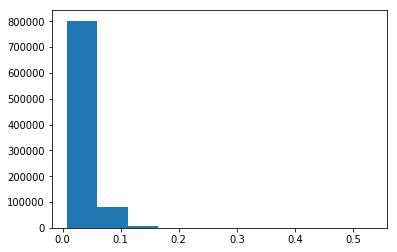

In [33]:
test_pred = np.array(sub[['target']])
test_pred = test_pred.reshape((len(test_pred)))
plt.hist(test_pred)
plt.show()